# d-q座標系におけるLCL回路のインピーダンス
下に示すLCL回路のd-q座標上でのインピーダンスを求める。

<img src="LCL.png" width="500px"/>

## Harnefors氏の論文に記載の方法
静止($\alpha$-$\beta$)座標系でのインピーダンスを回転(d-q)座標系に移す方法が以下の論文に記載されている。

- L. Harnefors, "Modeling of Three-Phase Dynamic Systems Using Complex Transfer Functions and Transfer Matrices," <i>IEEE Trans. Ind. Electron.</i>, vol. 54, no. 4, Aug. 2007, pp. 2239-2248.

以下ではその方法を試みる。$\alpha$-$\beta$座標系において次式が成り立つとする。
$$
\begin{bmatrix}
V_{\alpha}(s) \\ V_{\beta}(s)
\end{bmatrix}
= 
\begin{bmatrix}
Z^{s}(s) & 0  \\
0 & Z^{s}(s)
\end{bmatrix}
\begin{bmatrix}
I_{\alpha}(s) \\ I_{\beta}(s)
\end{bmatrix}
$$
これをd-q座標系に移すと，次式が成立するとする。
$$
\begin{bmatrix}
V_{d}(s) \\ V_{q}(s)
\end{bmatrix}
= 
\begin{bmatrix}
Z_{d}(s) & -Z_{q}(s) \\
Z_{q}(s) & Z_{d}(s)
\end{bmatrix}
\begin{bmatrix}
I_{d}(s) \\ I_{q}(s)
\end{bmatrix}
$$
(1)式と(2)式中のインピーダンスは次式のように変換できる。なお，実部と虚部を計算する際，ラプラス演算子$s$を便宜的に実数と見なす。
$$
\begin{align}
Z_{d}(s) &= \mathrm{Re} \left [ Z^{s}(s + j \omega_{1}) \right ] \\
Z_{q}(s) &= \mathrm{Im} \left [ Z^{s}(s + j \omega_{1}) \right ]
\end{align}
$$
以下では，三相LCL回路について，(3)式に基づいた解析的(analytical)な計算結果とLTspiceによる周波数スキャン(frequency reponse analysis, FRA)を比較する。

In [1]:
import sympy as sp

# 並列演算記号'//'のオーバーライド
## 関数parallelを定義
def parallel(self, other):
    return self * other / (self + other)
    
## Symbol, Add, Mulのアトリビュート__floordiv__()をparallel()でオーバーライド
sp.Symbol.__floordiv__ = parallel
sp.Add.__floordiv__ = parallel
sp.Mul.__floordiv__ = parallel

# 回路要素のシンボル
R1, L1 = sp.symbols('R_1 L_1', real = True, positive = True)
R2, L2 = sp.symbols('R_2 L_2', real = True, positive = True)
C, Rp = sp.symbols('C R_p', real = True, positive = True)

# ラプラス演算子のシンボル（便宜上，real = Trueとする）
s = sp.symbols('s', real = True)

# 基本波角周波数のシンボル
omega1 = sp.symbols('omega_1', real = True)

# 静止(α-β)座標系でのインピーダンス
Zs = R1 + s * L1 + (R2 + s * L2) // (1 / (s * C) // Rp)

# 回転(d-q)座標系でのインピーダンス
Z = Zs.subs(s, (s + sp.I * omega1))

# 対角成分
Zd = sp.re(Z).simplify()

## 対角成分の式の整理
### 分子多項式の抽出
Zd_num = sp.numer(Zd).expand().collect(s)

### 分子多項式の係数
A5 = Zd_num.coeff(s, 5)
A4 = Zd_num.coeff(s, 4)
A3 = Zd_num.coeff(s, 3)
A2 = Zd_num.coeff(s, 2)
A1 = Zd_num.coeff(s, 1)
A0 = Zd_num.coeff(s, 0)

### 分母多項式の抽出
Zd_den = sp.denom(Zd).expand().collect(s)

### 分母多項式の係数
B4 = Zd_den.coeff(s, 4)
B3 = Zd_den.coeff(s, 3)
B2 = Zd_den.coeff(s, 2)
B1 = Zd_den.coeff(s, 1)
B0 = Zd_den.coeff(s, 0)

# 非対角成分（干渉項）
Zq = sp.im(Z).simplify()

## 非対角成分の式の整理
### 分子多項式の抽出
Zq_num = sp.numer(Zq).expand().collect(s)

### 分子多項式の係数
C4 = Zq_num.coeff(s, 4)
C3 = Zq_num.coeff(s, 3)
C2 = Zq_num.coeff(s, 2)
C1 = Zq_num.coeff(s, 1)
C0 = Zq_num.coeff(s, 0)

### 分母多項式の抽出
Zq_den= sp.denom(Zq).expand().collect(s)

### 分母多項式の係数
D4 = Zq_den.coeff(s, 4)
D3 = Zq_den.coeff(s, 3)
D2 = Zq_den.coeff(s, 2)
D1 = Zq_den.coeff(s, 1)
D0 = Zq_den.coeff(s, 0)

In [2]:
import numpy as np

# 関数の定義と回路定数の代入
# 回路定数
_R1 = 50e-3 # [Ω]
_L1 = 0.8e-3 # [H]
_R2 = 100e-3 # [Ω]
_L2 = 1.6e-3 # [H]
_C = 50e-6 # [F]
_Rp = 1e3 # [Ω]
_omega1 = 2 * np.pi * 50 # [rad/s] 

# 対角成分関数の定義(lambdify)
_Zd = Zd.subs([(R1, _R1), (L1, _L1), (R2, _R2), (L2, _L2), (C, _C), (Rp, _Rp), (omega1, _omega1)])
Zd_FRA = sp.lambdify(s, _Zd, "numpy")

# 非対角成分（干渉項）関数の定義(lambdify)
_Zq = Zq.subs([(R1, _R1), (L1, _L1), (R2, _R2), (L2, _L2), (C, _C), (Rp, _Rp), (omega1, _omega1)])
Zq_FRA = sp.lambdify(s, _Zq, "numpy")

# 静止座標系関数の定義(lambdify)
_Zs = Zs.subs([(R1, _R1), (L1, _L1), (R2, _R2), (L2, _L2), (C, _C), (Rp, _Rp)])
Zs_FRA = sp.lambdify(s, _Zs, "numpy")

In [3]:
# Lambdifyを利用した数値データ生成
_omega = np.logspace(0, 5, 20000)
Zd_bode = Zd_FRA(1j * _omega)
Zq_bode = Zq_FRA(1j * _omega)
Zs_bode = Zs_FRA(1j * _omega)

In [4]:
# LTspiceの結果を読み込む
import re

## ファイルを開く
FILE = 'Ydq.log_cond2.txt'
file = open(FILE, 'r')

## 空のデータを準備
freq_LTS = np.array([])
Yd_LTS = np.array([])
Yq_LTS = np.array([])

## 読み込む
step = 0
for line in file:
    #print(line)
    line_split = re.split('[,\t]', line)
    
    #print(line_split)
    
    # 1行目を無視
    if line_split[0] == 'Freq.' or line_split[0] == '3\n' or line_split[0] == '\n':
        continue

    freq_LTS = np.append(freq_LTS, float(line_split[0]))
    Yd_LTS = np.append(Yd_LTS, float(line_split[1]) + 1j * float(line_split[2]))
    Yq_LTS = np.append(Yq_LTS, float(line_split[3]) + 1j * float(line_split[4]))
        
## ファイルを閉じる
file.close()

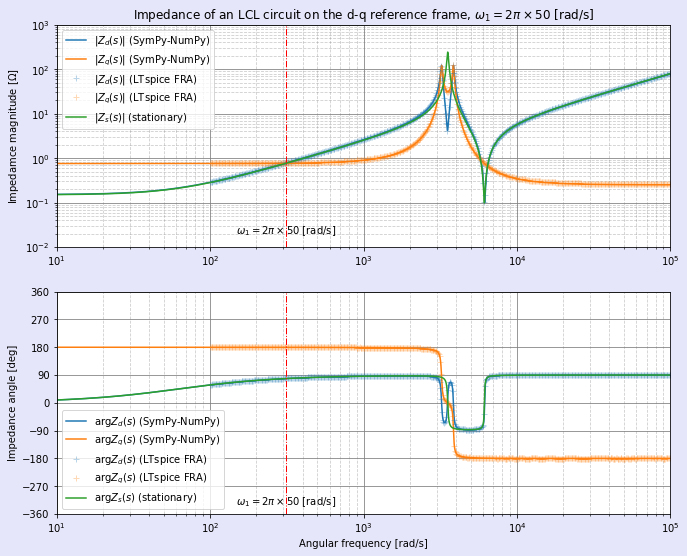

In [5]:
import matplotlib.pyplot as plt

# インピーダンスのプロット
fig, ax = plt.subplots(2, 1, figsize = (11, 9))
fig.patch.set_facecolor('lavender')

## 絶対値
ax[0].set_title(fr'Impedance of an LCL circuit on the d-q reference frame, $\omega_1 = 2 \pi \times 50$ [rad/s]')
ax[0].loglog(_omega, np.abs(Zd_bode), ls = '-', color = 'C0', label = r'$|Z_d(s)|$ (SymPy-NumPy)')
ax[0].loglog(_omega, np.abs(Zq_bode), ls = '-', color = 'C1', label = r'$|Z_q(s)|$ (SymPy-NumPy)')
ax[0].loglog(2 * np.pi * freq_LTS, np.abs(Yd_LTS / (Yd_LTS**2 + Yq_LTS**2)), ls = '', marker = '+', alpha = 0.3, label = r'$|Z_d(s)|$ (LTspice FRA)')
ax[0].loglog(2 * np.pi * freq_LTS, np.abs(-Yq_LTS / (Yd_LTS**2 + Yq_LTS**2)), ls = '', marker = '+', alpha = 0.3, label = r'$|Z_q(s)|$ (LTspice FRA)')
ax[0].loglog(_omega, np.abs(Zs_bode), ls = '-', color = 'C2', label = r'$|Z_s(s)|$ (stationary)')
ax[0].plot([_omega1, _omega1], [1e-2, 1e3], ls= '-.', lw = 1, color = 'red')
ax[0].text(_omega1, 2e-2, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[0].set_ylabel(r'Impedamce magnitude [$\Omega$]')
ax[0].set_xlim(1e1, 1e5)
ax[0].set_ylim(1e-2, 1e3)
ax[0].legend()
ax[0].grid(which='major', color='grey', ls = '-')
ax[0].grid(which='minor', color='grey', ls = '--', alpha = 0.4)

## 偏角
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(Zd_bode))), ls = '-', color = 'C0', label = r'$\arg Z_d(s)$ (SymPy-NumPy)')
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(-Zq_bode))), ls = '-', color = 'C1', label = r'$\arg Z_q(s)$ (SymPy-NumPy)')
ax[1].semilogx(2 * np.pi * freq_LTS, np.rad2deg(np.unwrap(np.angle(Yd_LTS / (Yd_LTS**2 + Yq_LTS**2)))), ls = '', marker = '+', alpha = 0.3, label = r'$\arg Z_d(s)$ (LTspice FRA)')
ax[1].semilogx(2 * np.pi * freq_LTS, np.rad2deg(np.unwrap(np.angle(Yq_LTS / (Yd_LTS**2 + Yq_LTS**2)))), ls = '', marker = '+', alpha = 0.3, label = r'$\arg Z_q(s)$ (LTspice FRA)')
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(Zs_bode))), ls = '-', color = 'C2', label = r'$\arg Z_s(s)$ (stationary)')
ax[1].plot([_omega1, _omega1], [-360, 360], ls = '-.', lw = 1, color = 'red')
ax[1].text(_omega1, -330, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[1].set_xlim(1e1, 1e5)
ax[1].set_xlabel('Angular frequency [rad/s]')
ax[1].set_ylabel('Impedance angle [deg]')
ax[1].set_ylim(-360, 360)
ax[1].set_yticks(range(-360, 450, 90))
ax[1].legend()
ax[1].grid(which = 'major', color = 'grey', linestyle = '-')
ax[1].grid(which = 'minor', color = 'grey', linestyle = '--', alpha = 0.4)

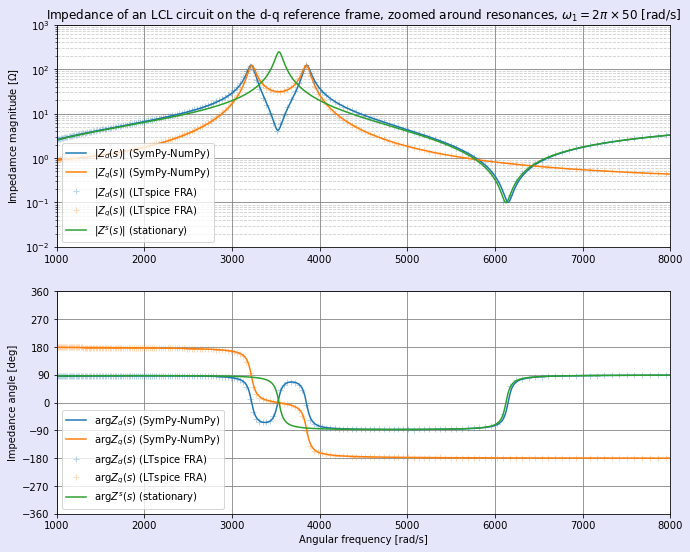

In [6]:
# インピーダンスのプロット（共振周波数あたりの拡大）
fig, ax = plt.subplots(2, 1, figsize = (11, 9))
fig.patch.set_facecolor('lavender')

## 絶対値
ax[0].set_title(fr'Impedance of an LCL circuit on the d-q reference frame, zoomed around resonances, $\omega_1 = 2 \pi \times 50$ [rad/s]')
ax[0].semilogy(_omega, np.abs(Zd_bode), ls = '-', color = 'C0', label = r'$|Z_d(s)|$ (SymPy-NumPy)')
ax[0].semilogy(_omega, np.abs(Zq_bode), ls = '-', color = 'C1', label = r'$|Z_q(s)|$ (SymPy-NumPy)')
ax[0].semilogy(2 * np.pi * freq_LTS, np.abs(Yd_LTS / (Yd_LTS**2 + Yq_LTS**2)), ls = '', marker = '+', alpha = 0.3, label = r'$|Z_d(s)|$ (LTspice FRA)')
ax[0].semilogy(2 * np.pi * freq_LTS, np.abs(-Yq_LTS / (Yd_LTS**2 + Yq_LTS**2)), ls = '', marker = '+', alpha = 0.3, label = r'$|Z_q(s)|$ (LTspice FRA)')
ax[0].semilogy(_omega, np.abs(Zs_bode), ls = '-', color = 'C2', label = r'$|Z^s(s)|$ (stationary)')
#ax[0].plot([_omega1, _omega1], [1e-2, 1e3], linestyle = '-.', linewidth = 1)
#ax[0].text(_omega1, 2e-2, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[0].set_ylabel(r'Impedamce magnitude [$\Omega$]')
ax[0].set_xlim(1e3, 8e3)
ax[0].set_ylim(1e-2, 1e3)
ax[0].legend(loc = 'lower left')
ax[0].grid(which='major', color='grey', ls = '-')
ax[0].grid(which='minor', color='grey', ls = '--', alpha = 0.4)

## 偏角
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(Zd_bode))), ls = '-', color = 'C0', label = r'$\arg Z_d(s)$ (SymPy-NumPy)')
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(-Zq_bode))), ls = '-', color = 'C1', label = r'$\arg Z_q(s)$ (SymPy-NumPy)')
ax[1].plot(2 * np.pi * freq_LTS, np.rad2deg(np.unwrap(np.angle(Yd_LTS / (Yd_LTS**2 + Yq_LTS**2)))), ls = '', marker = '+', alpha = 0.3, label = r'$\arg Z_d(s)$ (LTspice FRA)')
ax[1].plot(2 * np.pi * freq_LTS, np.rad2deg(np.unwrap(np.angle(Yq_LTS / (Yd_LTS**2 + Yq_LTS**2)))), ls = '', marker = '+', alpha = 0.3, label = r'$\arg Z_q(s)$ (LTspice FRA)')
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(Zs_bode))), ls = '-', color = 'C2', label = r'$\arg Z^s(s)$ (stationary)')
#ax[1].plot([_omega1, _omega1], [-360, 360], linestyle = '-.', linewidth = 1)
#ax[1].text(_omega1, -330, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[1].set_xlim(1e3, 8e3)
ax[1].set_xlabel('Angular frequency [rad/s]')
ax[1].set_ylabel('Impedance angle [deg]')
ax[1].set_ylim(-360, 360)
ax[1].set_yticks(range(-360, 450, 90))
ax[1].legend(loc = 'lower left')
ax[1].grid(which = 'major', color = 'grey', linestyle = '-')
ax[1].grid(which = 'minor', color = 'grey', linestyle = '--', alpha = 0.4)

In [7]:
# アドミタンス計算
Yd_bode = Zd_bode / (Zd_bode**2 + Zq_bode**2)
Yq_bode = Zq_bode / (Zd_bode**2 + Zq_bode**2)
Ys_bode = 1 / Zs_bode

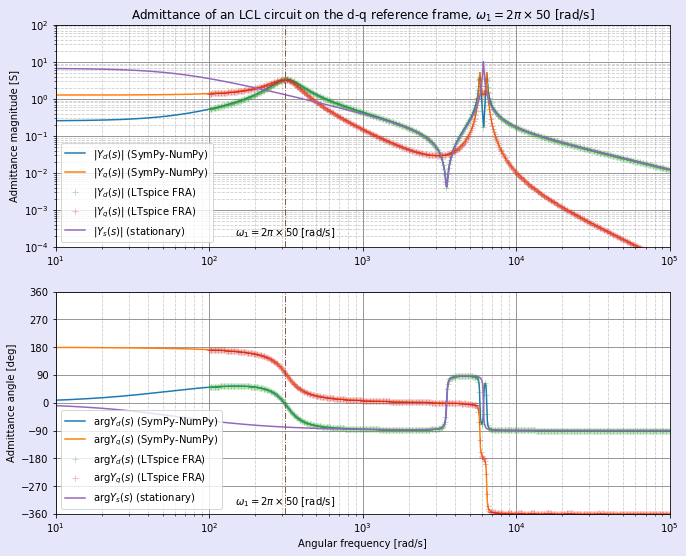

In [8]:
# アドミタンスのプロット
fig, ax = plt.subplots(2, 1, figsize = (11, 9))
fig.patch.set_facecolor('lavender')

## 絶対値
ax[0].set_title(fr'Admittance of an LCL circuit on the d-q reference frame, $\omega_1 = 2 \pi \times 50$ [rad/s]')
ax[0].loglog(_omega, np.abs(Yd_bode), ls = '-', label = r'$|Y_d(s)|$ (SymPy-NumPy)')
ax[0].loglog(_omega, np.abs(-Yq_bode), ls = '-', label = r'$|Y_q(s)|$ (SymPy-NumPy)')
ax[0].loglog(2 * np.pi * freq_LTS, np.abs(Yd_LTS), ls = '', marker = '+', alpha = 0.3, label = r'$|Y_d(s)|$ (LTspice FRA)')
ax[0].loglog(2 * np.pi * freq_LTS, np.abs(Yq_LTS), ls = '', marker = '+', alpha = 0.3, label = r'$|Y_q(s)|$ (LTspice FRA)')
ax[0].loglog(_omega, np.abs(Ys_bode), ls = '-', label = r'$|Y_s(s)|$ (stationary)')
ax[0].plot([_omega1, _omega1], [1e-4, 1e2], linestyle = '-.', linewidth = 1)
ax[0].text(_omega1, 2e-4, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[0].set_ylabel('Admittance magnitude [S]')
ax[0].set_xlim(1e1, 1e5)
ax[0].set_ylim(1e-4, 1e2)
ax[0].legend(loc = 'lower left')
ax[0].grid(which='major', color='grey', linestyle='-')
ax[0].grid(which='minor', color='grey', linestyle='--', alpha = 0.4)

## 偏角
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(Yd_bode))), ls = '-', label = r'$\arg Y_d(s)$ (SymPy-NumPy)')
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(-Yq_bode))), ls = '-', label = r'$\arg Y_q(s)$ (SymPy-NumPy)')
ax[1].semilogx(2 * np.pi * freq_LTS, np.rad2deg(np.unwrap(np.angle(Yd_LTS))), ls = '', marker = '+', alpha = 0.3, label = r'$\arg Y_d(s)$ (LTspice FRA)')
ax[1].semilogx(2 * np.pi * freq_LTS, np.rad2deg(np.unwrap(np.angle(Yq_LTS))), ls = '', marker = '+', alpha = 0.3, label = r'$\arg Y_q(s)$ (LTspice FRA)')
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(Ys_bode))), ls = '-', label = r'$\arg Y_s(s)$ (stationary)')
ax[1].plot([_omega1, _omega1], [-360, 360], linestyle = '-.', linewidth = 1)
ax[1].text(_omega1, -330, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[1].set_xlim(1e1, 1e5)
ax[1].set_xlabel('Angular frequency [rad/s]')
ax[1].set_ylabel('Admittance angle [deg]')
ax[1].set_ylim(-360, 360)
ax[1].set_yticks(range(-360, 450, 90))
ax[1].legend(loc = 'lower left')
ax[1].grid(which = 'major', color = 'grey', linestyle = '-')
ax[1].grid(which = 'minor', color = 'grey', linestyle = '--', alpha = 0.4)

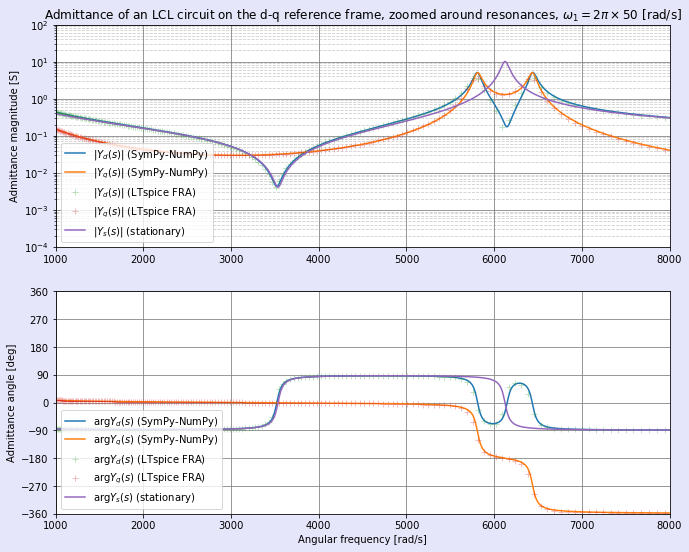

In [9]:
# アドミタンスのプロット（共振周波数あたりの拡大）
fig, ax = plt.subplots(2, 1, figsize = (11, 9))
fig.patch.set_facecolor('lavender')

## 絶対値
ax[0].set_title(fr'Admittance of an LCL circuit on the d-q reference frame, zoomed around resonances, $\omega_1 = 2 \pi \times 50$ [rad/s]')
ax[0].semilogy(_omega, np.abs(Yd_bode), ls = '-', label = r'$|Y_d(s)|$ (SymPy-NumPy)')
ax[0].semilogy(_omega, np.abs(-Yq_bode), ls = '-', label = r'$|Y_q(s)|$ (SymPy-NumPy)')
ax[0].semilogy(2 * np.pi * freq_LTS, np.abs(Yd_LTS), ls = '', marker = '+', alpha = 0.3, label = r'$|Y_d(s)|$ (LTspice FRA)')
ax[0].semilogy(2 * np.pi * freq_LTS, np.abs(Yq_LTS), ls = '', marker = '+', alpha = 0.3, label = r'$|Y_q(s)|$ (LTspice FRA)')
ax[0].semilogy(_omega, np.abs(Ys_bode), ls = '-', label = r'$|Y_s(s)|$ (stationary)')
#ax[0].plot([_omega1, _omega1], [1e-4, 1e2], linestyle = '-.', linewidth = 1)
#ax[0].text(_omega1, 2e-4, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[0].set_ylabel('Admittance magnitude [S]')
ax[0].set_xlim(1e3, 8e3)
ax[0].set_ylim(1e-4, 1e2)
ax[0].legend(loc = 'lower left')
ax[0].grid(which='major', color='grey', linestyle='-')
ax[0].grid(which='minor', color='grey', linestyle='--', alpha = 0.4)

## 偏角
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(Yd_bode))), ls = '-', label = r'$\arg Y_d(s)$ (SymPy-NumPy)')
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(-Yq_bode))), ls = '-', label = r'$\arg Y_q(s)$ (SymPy-NumPy)')
ax[1].plot(2 * np.pi * freq_LTS, np.rad2deg(np.unwrap(np.angle(Yd_LTS))), ls = '', marker = '+', alpha = 0.3, label = r'$\arg Y_d(s)$ (LTspice FRA)')
ax[1].plot(2 * np.pi * freq_LTS, np.rad2deg(np.unwrap(np.angle(Yq_LTS))), ls = '', marker = '+', alpha = 0.3, label = r'$\arg Y_q(s)$ (LTspice FRA)')
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(Ys_bode))), ls = '-', label = r'$\arg Y_s(s)$ (stationary)')
#ax[1].plot([_omega1, _omega1], [-360, 360], linestyle = '-.', linewidth = 1)
#ax[1].text(_omega1, -330, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[1].set_xlim(1e3, 8e3)
ax[1].set_xlabel('Angular frequency [rad/s]')
ax[1].set_ylabel('Admittance angle [deg]')
ax[1].set_ylim(-360, 360)
ax[1].set_yticks(range(-360, 450, 90))
ax[1].legend(loc = 'lower left')
ax[1].grid(which = 'major', color = 'grey', linestyle = '-')
ax[1].grid(which = 'minor', color = 'grey', linestyle = '--', alpha = 0.4)

## Rygg氏の学位論文に記載の方法
以下の学位論文において，修正対称座標インピーダンス(modified sequence domain impedance)からd-q座標系でのインピーダンスを導出する方法が記載されている。

- A. Rygg, "Impedance-based methods for small-signal analysis of power electronics dominated systems," Ph.D. Thesis, NTNU (Norges teknisk-naturvitenskapelige universitet), 2018

対象座標系において次式が成立するとする。
$$
\begin{bmatrix}
V_{p}(s + j \omega_{1}) \\ V_{n}(s - j \omega_{1})
\end{bmatrix}
= 
\begin{bmatrix}
Z_{pp}(s) & Z_{pn}(s) \\
Z_{np}(s) & Z_{nn}(s)
\end{bmatrix}
\begin{bmatrix}
I_{p}(s + j \omega_{1}) \\ I_{n}(s - j \omega_{1})
\end{bmatrix}
$$
ここで，$\boldsymbol{Z}_{pn}$を
$$
\boldsymbol{Z}_{pn} =
\begin{bmatrix}
Z_{pp}(s) & Z_{pn}(s) \\
Z_{np}(s) & Z_{nn}(s)
\end{bmatrix}
$$
とおく。これをd-q座標系におけるインピーダンス$\boldsymbol{Z}_{dq}$に変換することが可能である。
$$
\boldsymbol{Z}_{pn} = A_{Z}^{-1} \boldsymbol{Z}_{pn} A_{Z}
$$
ただし，
$$
A_{Z} = \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & j \\
1 & -j
\end{bmatrix}, \quad
A_{Z}^{-1} = A_{Z}^{*} = \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 \\
-j & j
\end{bmatrix}
$$
である。$A_{Z}$はユニタリ行列であり，共役転置行列$A_{Z}^{*}$が逆行列$A_{Z}^{-1}$に等しい。

三相平衡回路であり，$\alpha$-$\beta$でのインピーダンスを$Z^{s}(s)$とすれば，
$$
\begin{align}
Z_{pp}(s) &= Z^{s}(s + j \omega_{1}) \\
Z_{nn}(s) &= Z^{s}(s - j \omega_{1})
\end{align}
$$
となる。この条件で具体的に(3)式を計算すると，
$$
\begin{align}
Z_d(s) &= \frac{Z^{s}(s + j \omega_{1}) + Z^{s}(s - j \omega_{1})}{2} \\[5pt]
Z_q(s) &= \frac{Z^{s}(s + j \omega_{1}) - Z^{s}(s - j \omega_{1})}{2j}
\end{align}
$$
となる。

In [10]:
# SymPyでのZdとZqの導出
## 行列の定義
Zpp, Znn = sp.symbols('Zpp Znn')
Zpn = sp.Matrix([[Zpp, 0], [0, Znn]])
Az = 1 / sp.sqrt(2) * sp.Matrix([[1, sp.I], [1, -sp.I]])
Zdq_rygg = Az**(-1) * Zpn * Az

In [11]:
Zdq_rygg

Matrix([
[    Znn/2 + Zpp/2, -I*Znn/2 + I*Zpp/2],
[I*Znn/2 - I*Zpp/2,      Znn/2 + Zpp/2]])

In [12]:
## 三相RL回路での確認
R, L, omega = sp.symbols('R L \omega')
Zpp = R + (sp.I * (omega + omega1)) * L
Znn = R + (sp.I * (omega - omega1)) * L

In [13]:
## d軸インピーダンス
Zd_rygg = (Zpp + Znn) / 2
Zd_rygg.simplify()

I*L*\omega + R

In [14]:
## q軸インピーダンス
Zq_rygg = sp.I * (Zpp - Znn) / 2
Zq_rygg.simplify()

-L*omega_1

In [15]:
# 数値計算を試みる
from scipy import interpolate

## ±jω1を自由に足し引きできるように線形補完を定義する
Zs_interp = interpolate.interp1d(_omega, Zs_bode, fill_value = 'extrapolate')

In [16]:
## 変換行列Azを定義する
_Az = 1 / np.sqrt(2) * np.matrix([[1, 1j],[1, -1j]])

In [17]:
Zd_rygg = (Zs_interp(_omega + _omega1) + Zs_interp(_omega - _omega1)) / 2
Zq_rygg = (Zs_interp(_omega + _omega1) - Zs_interp(_omega - _omega1)) / 2j

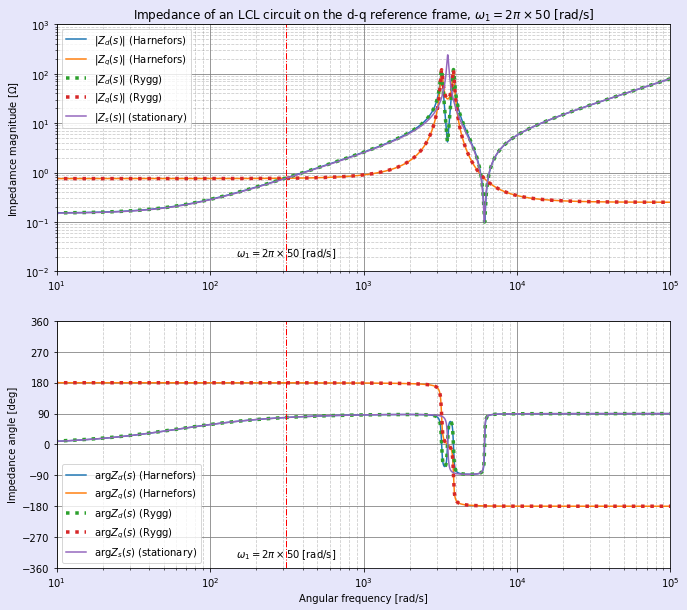

In [18]:
# インピーダンスのプロット（Harnefors氏とRygg氏の比較）
fig, ax = plt.subplots(2, 1, figsize = (11, 10))
fig.patch.set_facecolor('lavender')

## 絶対値
ax[0].set_title(fr'Impedance of an LCL circuit on the d-q reference frame, $\omega_1 = 2 \pi \times 50$ [rad/s]')
ax[0].loglog(_omega, np.abs(Zd_bode), ls = '-', color = 'C0', label = r'$|Z_d(s)|$ (Harnefors)')
ax[0].loglog(_omega, np.abs(Zq_bode), ls = '-', color = 'C1', label = r'$|Z_q(s)|$ (Harnefors)')
ax[0].loglog(_omega, np.abs(Zd_rygg), ls = ':', color = 'C2', lw = 3.5, label = r'$|Z_d(s)|$ (Rygg)')
ax[0].loglog(_omega, np.abs(Zq_rygg), ls = ':', color = 'C3', lw = 3.5, label = r'$|Z_q(s)|$ (Rygg)')
ax[0].loglog(_omega, np.abs(Zs_bode), ls = '-', color = 'C4', label = r'$|Z_s(s)|$ (stationary)')
ax[0].plot([_omega1, _omega1], [1e-2, 1e3], ls= '-.', lw = 1, color = 'red')
ax[0].text(_omega1, 2e-2, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[0].set_ylabel(r'Impedamce magnitude [$\Omega$]')
ax[0].set_xlim(1e1, 1e5)
ax[0].set_ylim(1e-2, 1e3)
ax[0].legend()
ax[0].grid(which='major', color='grey', ls = '-')
ax[0].grid(which='minor', color='grey', ls = '--', alpha = 0.4)

## 偏角
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(Zd_bode))), ls = '-', color = 'C0', label = r'$\arg Z_d(s)$ (Harnefors)')
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(-Zq_bode))), ls = '-', color = 'C1', label = r'$\arg Z_q(s)$ (Harnefors)')
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(Zd_rygg))), ls = ':', lw = 3.5, color = 'C2', label = r'$\arg Z_d(s)$ (Rygg)')
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(-Zq_rygg))), ls = ':', lw = 3.5, color = 'C3', label = r'$\arg Z_q(s)$ (Rygg)')
ax[1].semilogx(_omega, np.rad2deg(np.unwrap(np.angle(Zs_bode))), ls = '-', color = 'C4', label = r'$\arg Z_s(s)$ (stationary)')
ax[1].plot([_omega1, _omega1], [-360, 360], ls = '-.', lw = 1, color = 'red')
ax[1].text(_omega1, -330, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[1].set_xlim(1e1, 1e5)
ax[1].set_xlabel('Angular frequency [rad/s]')
ax[1].set_ylabel('Impedance angle [deg]')
ax[1].set_ylim(-360, 360)
ax[1].set_yticks(range(-360, 450, 90))
ax[1].legend()
ax[1].grid(which = 'major', color ='grey', linestyle='-')
ax[1].grid(which = 'minor', color = 'grey', linestyle='--', alpha = 0.4)

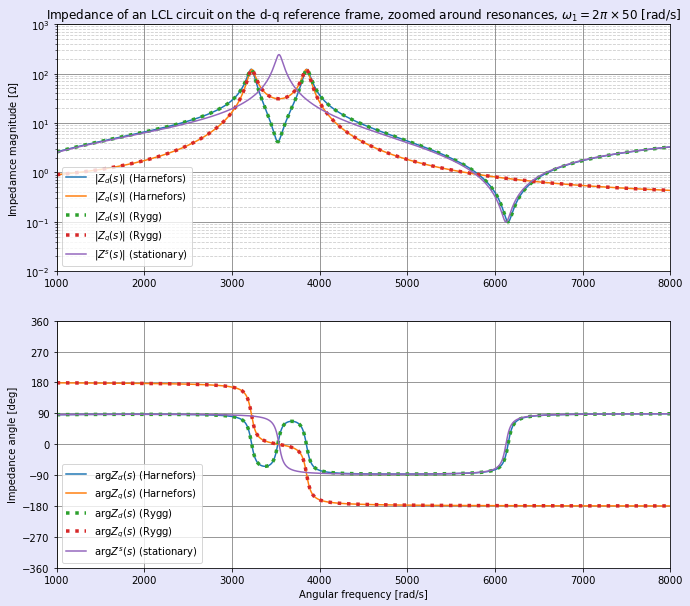

In [19]:
# インピーダンスのプロット（Harnefors氏とRygg氏の比較，共振周波数あたりの拡大）
fig, ax = plt.subplots(2, 1, figsize = (11, 10))
fig.patch.set_facecolor('lavender')

## 絶対値
ax[0].set_title(fr'Impedance of an LCL circuit on the d-q reference frame, zoomed around resonances, $\omega_1 = 2 \pi \times 50$ [rad/s]')
ax[0].semilogy(_omega, np.abs(Zd_bode), ls = '-', color = 'C0', label = r'$|Z_d(s)|$ (Harnefors)')
ax[0].semilogy(_omega, np.abs(Zq_bode), ls = '-', color = 'C1', label = r'$|Z_q(s)|$ (Harnefors)')
ax[0].semilogy(_omega, np.abs(Zd_rygg), ls = ':', color = 'C2', lw = 3.5, label = r'$|Z_d(s)|$ (Rygg)')
ax[0].semilogy(_omega, np.abs(Zq_rygg), ls = ':', color = 'C3', lw = 3.5, label = r'$|Z_q(s)|$ (Rygg)')
ax[0].semilogy(_omega, np.abs(Zs_bode), ls = '-', color = 'C4', label = r'$|Z^s(s)|$ (stationary)')
#ax[0].plot([_omega1, _omega1], [1e-2, 1e3], linestyle = '-.', linewidth = 1)
#ax[0].text(_omega1, 2e-2, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[0].set_ylabel(r'Impedamce magnitude [$\Omega$]')
ax[0].set_xlim(1e3, 8e3)
ax[0].set_ylim(1e-2, 1e3)
ax[0].legend(loc = 'lower left')
ax[0].grid(which='major', color = 'grey', ls = '-')
ax[0].grid(which='minor', color = 'grey', ls = '--', alpha = 0.4)

## 偏角
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(Zd_bode))), ls = '-', color = 'C0', label = r'$\arg Z_d(s)$ (Harnefors)')
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(-Zq_bode))), ls = '-', color = 'C1', label = r'$\arg Z_q(s)$ (Harnefors)')
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(Zd_rygg))), ls = ':', lw = 3.5, color = 'C2', label = r'$\arg Z_d(s)$ (Rygg)')
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(-Zq_rygg))), ls = ':', lw = 3.5, color = 'C3', label = r'$\arg Z_q(s)$ (Rygg)')
ax[1].plot(_omega, np.rad2deg(np.unwrap(np.angle(Zs_bode))), ls = '-', color = 'C4', label = r'$\arg Z^s(s)$ (stationary)')
#ax[1].plot([_omega1, _omega1], [-360, 360], linestyle = '-.', linewidth = 1)
#ax[1].text(_omega1, -330, r'$\omega_1 = 2 \pi \times 50$ [rad/s]', ha = 'center')
ax[1].set_xlim(1e3, 8e3)
ax[1].set_xlabel('Angular frequency [rad/s]')
ax[1].set_ylabel('Impedance angle [deg]')
ax[1].set_ylim(-360, 360)
ax[1].set_yticks(range(-360, 450, 90))
ax[1].legend(loc = 'lower left')
ax[1].grid(which = 'major', color = 'grey', linestyle='-')
ax[1].grid(which = 'minor', color = 'grey', linestyle='--', alpha = 0.4)